# Shortest Path

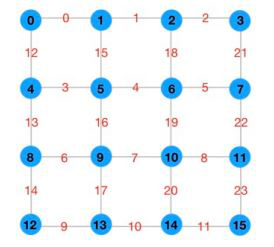

In [2]:
from IPython.display import display
from PIL import Image

path="4by4_grid.jpg"
display(Image.open(path))

Consider a 4*4 grid above.

There are 16 nodes and 24 edges in the grid. Given any 2 nodes in the grid, the target is to find
a shortest path between them. We use the dataset from (Xu et al. 2018), which was used to
demonstrate the effectiveness of semantic constraints for enhanced neural network learning.
Each example is a 4 by 4 grid G = (V,E), where |V | = 16,|E| = 24. The source and the destination
nodes are randomly picked up, as well as 8 edges are randomly removed to increase the
difficulty. The dataset is divided into 60/20/20 train/validation/test examples.

We apply NeurASP on this problem using the same dataset and the neural network model
from (Xu et al. 2018), but with a different training target: to maximize the probability of the
training data under the semantics of NeurASP.

## Data Format
In dataGen.py, a dictionary named "dataset" is constructed in the following way.

dataset is a dictionary with 6 keys: train, test, valid, train_label, test_label, valid_label.

dataset[‘train’] is a numpy array of size (966, 40). It consists of 966 data as follows.  

    [  
      data,  
      ...,  
      data  
    ]  
    
where data is a vector (numpy array) of length 40. For example, the data shown below  

    [  
      11101 10111 10001 11110 1010  
      01000 00000 00010 0  
    ]  

means the edges 3, 6, 11, 12, 13, 19, 21, 23 are removed (denoted by 0 in the 1st line); and the nodes 1 and 13 are the starting and ending nodes (denoted by 1 in the 2nd line).

dataset[‘train_label’] is a numpy array of size (996, 24). It consists of 966 label as  
follows.  

    [  
      label,  
      ...,  
      label  
    ]  

where label is a vector (numpy array) of length 24. For example, the label shown below 

    [  
      00000 00000 00000 11100 0000  
    ]  

means that the edges 15, 16, 17 form a shortest path.  
dataset[‘test’] is a numpy array of size (322, 40).  
dataset[‘valid’] is a numpy array of size (322, 40).  
dataset[‘test_label’] is a numpy array of size (322, 24).  
dataset[‘valid_label’] is a numpy array of size (322, 24).  


## Imports


In [ ]:
import sys
sys.path.append("../../")
import time

import torch

from neurasp import NeurASP
from network import FC
from dataGen import obsList, obsListTest, dataList, dataListTest



## NeurASP program
### Neural Rule

In [ ]:
nnRule = '''
nn(sp(24, g), [true, false]).
'''

### ASP Rule

In [ ]:
aspRule = '''
sp(X) :- sp(X,g,true).
sp(0,1) :- sp(0).
sp(1,2) :- sp(1).
sp(2,3) :- sp(2).
sp(4,5) :- sp(3).
sp(5,6) :- sp(4).
sp(6,7) :- sp(5).
sp(8,9) :- sp(6).
sp(9,10) :- sp(7).
sp(10,11) :- sp(8).
sp(12,13) :- sp(9).
sp(13,14) :- sp(10).
sp(14,15) :- sp(11).
sp(0,4) :- sp(12).
sp(4,8) :- sp(13).
sp(8,12) :- sp(14).
sp(1,5) :- sp(15).
sp(5,9) :- sp(16).
sp(9,13) :- sp(17).
sp(2,6) :- sp(18).
sp(6,10) :- sp(19).
sp(10,14) :- sp(20).
sp(3,7) :- sp(21).
sp(7,11) :- sp(22).
sp(11,15) :- sp(23).
sp(X,Y) :- sp(Y,X).
'''

### Constraints

In [ ]:
constraints = {}

constraints['nr'] = '''
% [nr] 1. No removed edges should be predicted
mistake :- sp(X), removed(X).
'''

constraints['p'] = '''
% [p] 2. Prediction must form simple path(s)
% that is: the degree of nodes should be either 0 or 2
mistake :- X=0..15, #count{Y: sp(X,Y)} = 1.
mistake :- X=0..15, #count{Y: sp(X,Y)} >= 3.
'''

constraints['r'] = '''
% [r] 3. Every 2 nodes in the prediction must be reachable
reachable(X, Y) :- sp(X, Y).
reachable(X, Y) :- reachable(X, Z), sp(Z, Y).
mistake :- sp(X, _), sp(Y, _), not reachable(X, Y).
'''

constraints['o'] = '''
% [o] 4. Predicted path should contain least edges
:~ sp(X). [1, X]
'''


########
# Set up the list C of constraints used for training
# The list C could contain any combination of elements in {'nr', 'p', 'r', 'o'}
########

C = ['p', 'r', 'o']
aspProgram = aspRule
for c in C:
	aspProgram += constraints[c]

########
# Set up the list of constraint combinations for testing accuracy
########

combinations = [['nr'], ['p'], ['r'], ['nr', 'p'], ['nr', 'r'], ['p', 'r'], ['nr', 'p', 'r'], ['nr', 'p', 'r', 'o']]
combinations = [aspRule + ''.join([constraints[c] for c in combination]) for combination in combinations]








## Neural Network Instantiation
- Instantiate neural networks.
- Define nnMapping: a dictionary that maps neural network names (i.e., strings) to the neural network objects (i.e., torch.nn.Module object)
- Define optimizers: a dictionary that specifies the optimizer for each network (we use the Adam optimizer here).

In [ ]:

m = FC(40, 50, 50, 50, 50, 50, 24)
nnMapping = {'sp': m}
optimizers = {'sp': torch.optim.Adam(m.parameters(), lr=0.001)}

## Create NeurASP Object

We use all constraints to train the neural network, which corresponds to the experiment nr-p-r-opt at the table at the end of this document. 

In [ ]:
NeurASPobj = NeurASP(nnRule+aspProgram, nnMapping, optimizers)

## Training and Testing

Note that our target is to find the path with the minimal length, which is represented by the optimal stable models of the logic program. To find the optimal stable models instead of stable models during training, we need to specify "opt=True" in the learning function.

In [ ]:
saveModelPath = 'data/model.pt'
startTime = time.time()

print('\n\nWill test whether the neural network prediction satisfies the following list of constraints ...\n')
for idx, constraint in enumerate(combinations):
    print('Constraint {} is\n{}\n-------------------'.format(idx+1, constraint))

for i in range(50):
    print('Continuously training for 10 epochs round {}...'.format(i+1))
    time1 = time.time()
    NeurASPobj.learn(dataList=dataList, obsList=obsList, epoch=10, opt=True, smPickle='data/stableModels.pickle')
    time2 = time.time()
    NeurASPobj.testConstraint(dataList=dataListTest, obsList=obsListTest, mvppList=combinations)
    print("--- train time: %s seconds ---" % (time2 - time1))
    print("--- test time: %s seconds ---" % (time.time() - time2))
    print('--- total time from beginning: %s minutes ---' % int((time.time() - startTime)/60) )

print('Storing the trained model into {}'.format(saveModelPath))
torch.save(m.state_dict(), saveModelPath)

More results: The following table shows the constraint accuracy of the same MLP trained with
different constraints (denoted in the parentheses) for 500 epochs.

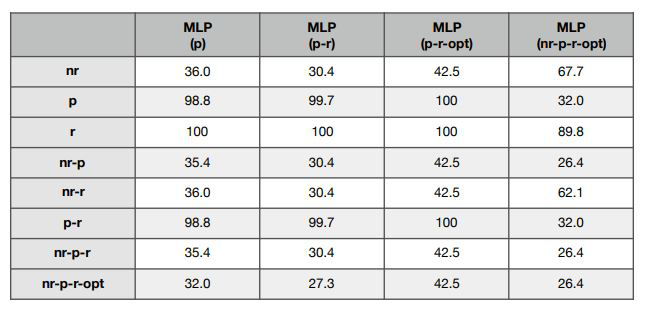

In [3]:
path="constraint_accuracies.jpg"
display(Image.open(path))